<a href="https://colab.research.google.com/github/woodRock/fishy-business/blob/main/code/identification/part/R01_S02_Identification_Part_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research objective - Identification, Sub-objective - Species

This notebook is a contribution to the first research objective - fish identification. This work covers sub-objective 1 - binary classification task to predict fish species.

## Feature Selection

This notebook explores different feature selection methods, as dimensionality reduction techniques, for more efficient models, that maintain (or even improve) classification accuracy.


In [39]:
!pip install skfeature-chappers

In [40]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import pickle

In [41]:
run = 1
seed = 1617 * run
np.random.seed(seed)

In [42]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.listdir('/content/drive/My Drive')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

path = ['drive', 'MyDrive', 'AI', 'fish', 'REIMS_data.xlsx']
path = os.path.join(*path)

# Load the dataset
data = pd.read_excel(path)

print("[INFO] Reading the dataset.")
raw = pd.read_excel(path)

data = raw[~raw['m/z'].str.contains('HM')]
data = data[~data['m/z'].str.contains('QC')]
data = data[~data['m/z'].str.contains('HM')]
X = data.drop('m/z', axis=1) # X contains only the features.
# y = data['m/z'].apply(lambda x:
#                           [1,0,0,0,0,0] if 'Fillet' in x
#                     else ([0,1,0,0,0,0] if 'Heads' in x
#                     else ([0,0,1,0,0,0] if 'Livers' in x
#                     else ([0,0,0,1,0,0] if 'Skins' in x
#                     else ([0,0,0,0,1,0] if 'Guts' in x
#                     else ([0,0,0,0,0,1] if 'Frames' in x
#                     else None ))))))  # Labels for fish parts
y = data['m/z'].apply(lambda x:
                          0 if 'Fillet' in x
                    else  1 if 'Heads' in x
                    else (2 if 'Livers' in x
                    else (3 if 'Skins' in x
                    else (4 if 'Guts' in x
                    else (5 if 'Frames' in x
                    else None )))))  # For fish parts
xs = []
ys = []
for (x,y) in zip(X.to_numpy(),y):
    if y is not None and not np.isnan(y):
       xs.append(x)
       ys.append(y)
X = np.array(xs)
y = np.array(ys)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Reading the dataset.


In [43]:
inc = 20
no_features = X.shape[1]
j = np.arange(inc,no_features,inc) # [20, 1020]
j = np.append(j, no_features) # [20,1023]

print(f"[DEBUG] min: {min(j)}, max: {max(j)}")
assert min(j) == 20, "j should start at 20 features"
assert max(j) == 1023, "j should end at 1023 features"
assert (j == sorted(j)).all, "range should be sorted in ascending order."

[DEBUG] min: 20, max: 1023


In [44]:
from skfeature.function.similarity_based import reliefF
from skfeature.function.information_theoretical_based import MRMR
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC as svm

methods = { "reliefF" : reliefF.reliefF, "mrmr": MRMR.mrmr, "chi2": chi2}
results = { "reliefF" : [], "mrmr": [], "chi2": []} #, "pso": []}
penalty = 'l1'

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import balanced_accuracy_score

def normalize(X_train, X_test):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [46]:
# least populated class only has 3 instances
# no_folds <= 3 instances
folds = 3

for k in tqdm(j):
    for name, fs_method in methods.items():
        train_accs = []
        test_accs = []
        skf = StratifiedKFold(n_splits=folds, random_state=1234, shuffle=True)

        for train, test in skf.split(X, y):
            X_train, X_test = (X[train], X[test])
            y_train, y_test = y[train], y[test]
            X_train, X_test = normalize(X_train, X_test)

            fs = SelectKBest(fs_method, k=k)
            X_train = fs.fit_transform(X_train, y_train)
            X_test = fs.transform(X_test)

            model = svm(penalty='l1', dual=False, tol=1e-3, max_iter=5_000)
            clf = model.fit(X_train, y_train)

            y_predict = model.predict(X_train)
            train_acc = balanced_accuracy_score(y_train, y_predict)
            train_accs.append(train_acc)
            y_predict = model.predict(X_test)
            test_acc = balanced_accuracy_score(y_test, y_predict)
            test_accs.append(test_acc)

        no_fea = k
        results[name].append((no_fea, np.mean(train_accs), np.mean(test_accs)))

100%|██████████| 52/52 [00:58<00:00,  1.13s/it]


In [47]:
# print the results for posterity
results

{'reliefF': [(20, 0.861111111111111, 0.5277777777777778),
  (40, 0.8888888888888888, 0.5555555555555556),
  (60, 0.9583333333333334, 0.6666666666666666),
  (80, 0.9722222222222222, 0.5),
  (100, 0.9722222222222222, 0.5555555555555555),
  (120, 1.0, 0.4444444444444445),
  (140, 1.0, 0.5555555555555557),
  (160, 1.0, 0.5833333333333334),
  (180, 1.0, 0.6666666666666666),
  (200, 1.0, 0.6666666666666666),
  (220, 1.0, 0.6388888888888888),
  (240, 1.0, 0.5),
  (260, 1.0, 0.5555555555555555),
  (280, 1.0, 0.5833333333333334),
  (300, 1.0, 0.6111111111111112),
  (320, 1.0, 0.6111111111111112),
  (340, 1.0, 0.5833333333333334),
  (360, 1.0, 0.5000000000000001),
  (380, 1.0, 0.5555555555555555),
  (400, 1.0, 0.5277777777777778),
  (420, 1.0, 0.5833333333333334),
  (440, 1.0, 0.5555555555555557),
  (460, 1.0, 0.638888888888889),
  (480, 1.0, 0.6111111111111112),
  (500, 1.0, 0.6111111111111112),
  (520, 1.0, 0.5833333333333334),
  (540, 1.0, 0.6388888888888888),
  (560, 1.0, 0.5833333333333334)

name: reliefF
 k=(20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1023)
 train: (0.861111111111111, 0.8888888888888888, 0.9583333333333334, 0.9722222222222222, 0.9722222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
 test: (0.5277777777777778, 0.5555555555555556, 0.6666666666666666, 0.5, 0.5555555555555555, 0.4444444444444445, 0.5555555555555557, 0.5833333333333334, 0.6666666666666666, 0.6666666666666666, 0.6388888888888888, 0.5, 0.5555555555555555, 0.5833333333333334, 0.6111111111111112, 0.6111111111111112, 0.5833333333333334, 0.5000000000000001, 0.5555555555555555, 0.5277777777777778, 0.

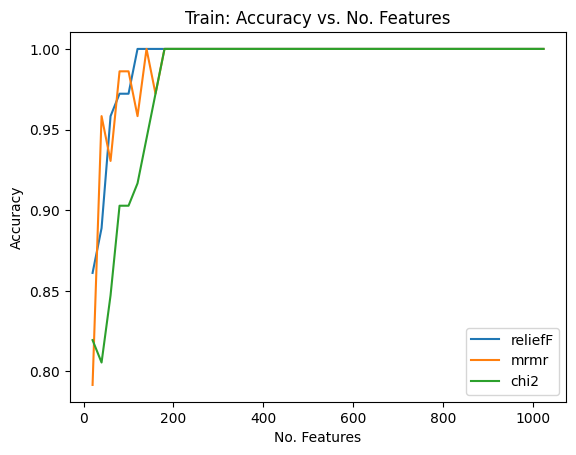

In [61]:
dataset="Species"

for name, result in results.items():
    k, train, test = zip(*result)
    plt.plot(k, train, label=name)
    print(f"name: {name}\n k={k}\n train: {train}\n test: {test}")
    assert len(k) == len(train), "length of k should equal length of train"
    assert len(k) == len(test), "length of k should equal length of test"
    # print(f"k = {k}")
    # assert (k == sorted(k)), "k should be in order of index ascending"

plt.title("Train: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-train", dpi=500)
plt.show()

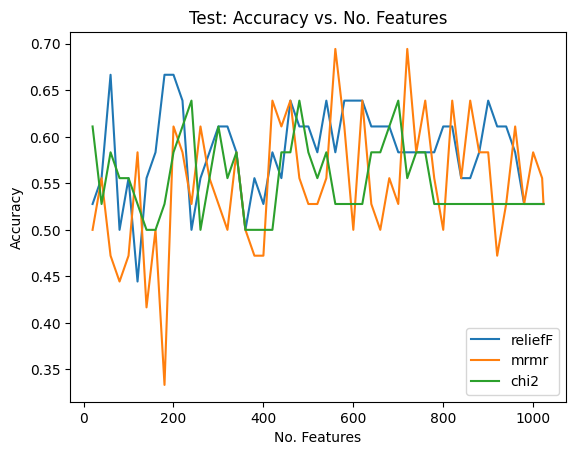

In [50]:
for name, result in results.items():
    k, train, test = zip(*result)
    plt.plot(k, test, label=name)

plt.title("Test: Accuracy vs. No. Features")
plt.xlabel("No. Features")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(fname=f"accuracy-features-{dataset}-test", dpi=500)
plt.show()

In [51]:
for method, result in results.items():
    k, train, test = list(zip(*result))
    best_k = np.argmax(test)
    print(f"{method} performed best at {k[best_k]} features, with {train[best_k]} training accuracy, and {test[best_k]} test accuracy.")

k, train, test = results['mrmr'][-1]
print(f"Full-dataset with {k} features, with {train} training accuracy, and {test} test accuracy.")

reliefF performed best at 60 features, with 0.9583333333333334 training accuracy, and 0.6666666666666666 test accuracy.
mrmr performed best at 560 features, with 1.0 training accuracy, and 0.6944444444444445 test accuracy.
chi2 performed best at 240 features, with 1.0 training accuracy, and 0.638888888888889 test accuracy.
Full-dataset with 1023 features, with 1.0 training accuracy, and 0.5277777777777778 test accuracy.


In [53]:
from prettytable import PrettyTable

def show_results(results, label='Method'):
    table = PrettyTable([label, 'Best K', 'Train', 'Test'])

    for name, result in results.items():
        k, train, test = list(zip(*result))
        best_k = np.argmax(test)
        vals = [k[best_k], train[best_k], test[best_k]]
        row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
        table.add_row(np.concatenate([[name], row]))

    k, train, test = results['mrmr'][-1]
    vals = [k, train, test]
    row = ['%.4f' % elem if i != 0 else elem for i, elem in enumerate(vals) ]
    table.add_row(np.concatenate([['full'], row]))

    print('\n') # tqdm messses with table border.
    print(table)

show_results(results)



+---------+--------+--------+--------+
|  Method | Best K | Train  |  Test  |
+---------+--------+--------+--------+
| reliefF |   60   | 0.9583 | 0.6667 |
|   mrmr  |  560   | 1.0000 | 0.6944 |
|   chi2  |  240   | 1.0000 | 0.6389 |
|   full  |  1023  | 1.0000 | 0.5278 |
+---------+--------+--------+--------+
